# PHONE PRICE ANALYSIS & RECOMMENDATION SYSTEM

### 1. Preprocessing - Data Cleaning & Normalization

In [3]:
# Installing all liberies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from bs4 import BeautifulSoup
import requests
import time
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load & View first 5 records in the dataset

df = pd.read_csv("Jumia_Phones.csv")
df.head()

,Name,Review,Price_NGN
0,"<h3 class=""name"">XIAOMI Redmi PAD SE 4GB RAM/1...","<div class=""rev""><div class=""stars _s"">4.5 out...","<div class=""prc"">₦ 221,160</div>"
1,"<h3 class=""name"">XIAOMI Redmi A5 6.88"" 3GB RAM...","<div class=""rev""><div class=""stars _s"">4.2 out...","<div class=""prc"">₦ 96,659</div>"
2,"<h3 class=""name"">XIAOMI Redmi A5 6.88"" 4GB RAM...","<div class=""rev""><div class=""stars _s"">4.1 out...","<div class=""prc"">₦ 111,684</div>"
3,"<h3 class=""name"">Samsung Galaxy A05 6.7"" 4GB R...","<div class=""rev""><div class=""stars _s"">4 out o...","<div class=""prc"">₦ 120,577</div>"
4,"<h3 class=""name"">XIAOMI REDMI A5 - 6.88 4GB...","<div class=""rev""><div class=""stars _s"">4.1 out...","<div class=""prc"">₦ 109,450</div>"


In [5]:
# Function to parse each phone name
def phone_name(Name):
    # Remove HTML tags
    text = BeautifulSoup(Name, "html.parser").get_text().strip()

    # Initialize fields
    brand = model = color = android = None
    screen = ram = rom = battery = None

    # Brand (first word, or Samsung/Xiaomi etc.)
    brand_match = re.match(r'([A-Z]+)', text, re.IGNORECASE)
    if brand_match:
        brand = brand_match.group(1).upper()

    # RAM (e.g., 4GB RAM, 4/128GB, 6+128GB)
    ram_match = re.search(r'(\d+)\s*[+/]?\s*(?:GB)?\s*RAM', text, re.IGNORECASE)
    if not ram_match:
        ram_match = re.search(r'(\d+)\s*[+/]\s*\d+\s*GB', text, re.IGNORECASE)
    if ram_match:
        ram = int(ram_match.group(1))

    # ROM (e.g., 128GB ROM)
    rom_match = re.search(r'[\s+/](\d{2,4})\s*GB\s*ROM', text, re.IGNORECASE)
    if not rom_match:
        rom_match = re.search(r'[\s+/](\d{2,4})\s*GB', text, re.IGNORECASE)
    if rom_match:
        rom = int(rom_match.group(1))

     # Screen Size (e.g., 6.88", 11", etc.)
    screen_match = re.search(r'(\d{1,2}(?:\.\d{1,2})?)\s*([”]?|in(?:ch)?)?', text, re.IGNORECASE)
    if screen_match:
        screen = float(screen_match.group(1))
        
     # Battery - match formats like 5000mAh, 6000mAh+4000mAh, etc.
    battery_match = re.search(r'(\d{4,5})\s*mAh(?:\s*\+\s*(\d{4,5})\s*mAh)?', text, re.IGNORECASE)
    if battery_match:
        try:
            battery = int(battery_match.group(1))
            if battery_match.group(2):
                battery += int(battery_match.group(2))  # Add both parts
        except:
            battery = None

    # Android version (e.g. Android 13)
    android_match = re.search(r'Android\s*(\d+)', text, re.IGNORECASE)
    if android_match:
        android = f"Android {android_match.group(1)}"
        

    # Color (usually the last word or phrase)
    color_match = re.search(r'-\s*([A-Za-z ]+)$', text)
    if not color_match:
        color_match = re.search(r'\b(Black|Blue|Green|Gray|Silver|White|Gold|Red|Pink)\b', text, re.IGNORECASE)
    if color_match:
        color = color_match.group(1).strip().capitalize()

    # Model (between brand and screen/RAM)
        # --- Clean Model Name from full text ---
    model = text

    # 1. Remove brand from the front
    if brand:
        model = re.sub(rf'\b{re.escape(brand)}\b', '', model, flags=re.IGNORECASE)

    # 2. Remove screen size like 6.88", 6.7 inch, etc.
    if screen:
        model = re.sub(rf'{screen}\s*(["”]?|inches?|inch)?', '', model, flags=re.IGNORECASE)

    # 3. Remove RAM/ROM (like 4+128GB, 6/128GB, 4GB RAM)
    model = re.sub(r'(\d+\s*[+/]?\s*\d*)\s*GB\s*(RAM|ROM)?', '', model, flags=re.IGNORECASE)
    model = re.sub(r'\d+\s*GB\s*(RAM|ROM)?', '', model, flags=re.IGNORECASE)

    # 4. Remove Android version
    model = re.sub(r'Android\s*\d+', '', model, flags=re.IGNORECASE)

    # 5. Remove battery specs
    model = re.sub(r'\d{4,5}\s*mAh(?:\s*\+\s*\d{4,5})?', '', model, flags=re.IGNORECASE)

    # 6. Remove color
    if color:
        model = re.sub(re.escape(color), '', model, flags=re.IGNORECASE)

    # 7. Remove leftover symbols or slashes
    model = re.sub(r'[\/\\\-\+_"]+', ' ', model)

    # 8. Final cleanup: strip multiple spaces and punctuation
    model = re.sub(r'\s+', ' ', model).strip(' -_ ').strip()

    # Capitalize each word for consistency
    model = model.upper()


    return pd.Series([brand, model, screen, ram, rom, battery, android, color])

# Apply to your existing DataFrame
df[['Brand', 'Model', 'Screen', 'RAM', 'ROM', 'Battery', 'Android', 'Color']] = df['Name'].apply(phone_name)

# Preview the new columns
df[['Brand', 'Model', 'Screen', 'RAM', 'ROM', 'Battery', 'Android', 'Color']].head()

,Brand,Model,Screen,RAM,ROM,Battery,Android,Color
0,XIAOMI,REDMI PAD SE WIFI ONLY,4.0,4.0,128.0,NaN,Android 13,Grey
1,XIAOMI,REDMI A5 6.88,5.0,3.0,64.0,NaN,Android 15,Black
2,XIAOMI,REDMI A5 6.88,5.0,4.0,128.0,NaN,Android 15,Ocean blue
3,SAMSUNG,GALAXY A05 6.7,5.0,4.0,64.0,NaN,Android 13,Black
4,XIAOMI,REDMI A5 6.,5.0,4.0,128.0,NaN,None,Black


In [6]:
# Checking for unique count of model in the dataset
df['Model'].nunique()

29

In [7]:
# Inspecting the entire  dataset
print(df.shape)
print(df.duplicated().sum())

(2000, 11)
1960


In [8]:
# Checking for unique model in the dataset
df['Model'].unique()

array(['REDMI PAD SE WIFI ONLY', 'REDMI A5 6.88', 'GALAXY A05 6.7',
       'REDMI A5 6.', 'C75X 6.67 ,,50MP 8MP,ANDROID,',
       'CITY 100 7.65MM SLIM DESIGN',
       '105 AFRICAN EDITION,1.77 ,4MB 4MB,800MAH, DUAL SIM', "S24 6.6''",
       "REDMI 14C 6.88''", "POWER 70 6.67'' HD P70 MAH CASE",
       'S25 ULTRA 6.78 AMOLED 256 8 4G ANDROID', 'T101 1.8 DUAL SIM',
       "POWER 70 6.67'' HD ANDRIOD P70 MAH CASE", 'REDMI A3 PRO 6.88',
       'S23 6.78 FHD 256 ROM', "REDMI 14C 6.88'' MIDNIGHT ..",
       'D5 SMARTPHONE 6.52INCH IPS HD', 'GALAXY A06 6.7',
       '2165 WIRELESS FM, TORCH, DUAL SIM PHONE 24 MONTH WARRANTY',
       'POP 9 6.67', 'REDMI NOTE 14 6.67 HYPEROS',
       'GALAXY A DUAL SIM, 48MP CAMERA', 'M5, ,4G 6.52 SMARTPHONE 0MAH,',
       'C71 , 6.88', 'C61 6.71', 'REDMI A3X 6.71 .', 'HOT 50 PRO 6.78',
       'D5 SMARTPHONE 6.52INCH IPS HD ，',
       'POVA6 COLOR ANDROID SMART PHONE WITH FREE EARPHONES'],
      dtype=object)

In [9]:
# Using dictionary mapping & regex (patterns) to futher clean model names
pattern_map = {
    r'^REDMI PAD SE WIFI ONLY.*': 'REDMI PAD SE',
    r'^REDMI A5 6\.88.*': 'REDMI A5',
    r'^REDMI A5 6\..*': 'REDMI A5',
    r'^GALAXY A05 6\.7.*': 'GALAXY A05',
    r'^C75X 6\.67.*': 'C75X',
    r'^CITY 100 7\.65MM.*': 'CITY 100',
    r'^105 AFRICAN EDITION.*': '105 AFRICAN EDITION',
    r'^S24 6\.6.*': 'S24',
    r'^REDMI 14C 6\.88.*': 'REDMI 14C',
    r'^POWER 70 6\.67.*': 'POWER 70',
    r'^S25 ULTRA 6\.78.*': 'S25 ULTRA',
    r'^T101 1\.8.*': 'T101',
    r'^REDMI A3 PRO 6\.88.*': 'REDMI A3 PRO',
    r'^S23 6\.78.*': 'S23',
    r'^D5 SMARTPHONE 6\.52.*': 'D5 SMARTPHONE',
    r'^GALAXY A06 6\.7.*': 'GALAXY A06',
    r'^2165 WIRELESS FM.*': '2165 WIRELESS FM',
    r'^POP 9 6\.67.*': 'POP 9',
    r'^REDMI NOTE 14 6\.67.*': 'REDMI NOTE 14',
    r'^GALAXY A DUAL SIM.*': 'GALAXY A',
    r'^M5.*': 'M5',
    r'^C71.*': 'C71',
    r'^C61 6\.71.*': 'C61',
    r'^REDMI A3X 6\.71.*': 'REDMI A3X',
    r'^HOT 50 PRO 6\.78.*': 'HOT 50 PRO',
    r'^POVA6 COLOR.*': 'POVA6'
}

# Apply all replacements at once
df['Model'] = df['Model'].replace(pattern_map, regex=True)

In [10]:
# Recheck cleaned unique models
df['Model'].unique()

array(['REDMI PAD SE', 'REDMI A5', 'GALAXY A05', 'C75X', 'CITY 100',
       '105 AFRICAN EDITION', 'S24', 'REDMI 14C', 'POWER 70', 'S25 ULTRA',
       'T101', 'REDMI A3 PRO', 'S23', 'D5 SMARTPHONE', 'GALAXY A06',
       '2165 WIRELESS FM', 'POP 9', 'REDMI NOTE 14', 'GALAXY A', 'M5',
       'C71', 'C61', 'REDMI A3X', 'HOT 50 PRO', 'POVA6'], dtype=object)

In [11]:
# Previewing the first 5 rows in the dataframe
df[['Brand', 'Model', 'Screen', 'RAM', 'ROM', 'Battery', 'Android', 'Color']].head()

,Brand,Model,Screen,RAM,ROM,Battery,Android,Color
0,XIAOMI,REDMI PAD SE,4.0,4.0,128.0,NaN,Android 13,Grey
1,XIAOMI,REDMI A5,5.0,3.0,64.0,NaN,Android 15,Black
2,XIAOMI,REDMI A5,5.0,4.0,128.0,NaN,Android 15,Ocean blue
3,SAMSUNG,GALAXY A05,5.0,4.0,64.0,NaN,Android 13,Black
4,XIAOMI,REDMI A5,5.0,4.0,128.0,NaN,None,Black


In [12]:
# Previewing model in a sorted order
sorted(df['Model'].unique())

['105 AFRICAN EDITION',
 '2165 WIRELESS FM',
 'C61',
 'C71',
 'C75X',
 'CITY 100',
 'D5 SMARTPHONE',
 'GALAXY A',
 'GALAXY A05',
 'GALAXY A06',
 'HOT 50 PRO',
 'M5',
 'POP 9',
 'POVA6',
 'POWER 70',
 'REDMI 14C',
 'REDMI A3 PRO',
 'REDMI A3X',
 'REDMI A5',
 'REDMI NOTE 14',
 'REDMI PAD SE',
 'S23',
 'S24',
 'S25 ULTRA',
 'T101']

In [13]:
# Inspecting the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       2000 non-null   object 
 1   Review     2000 non-null   object 
 2   Price_NGN  2000 non-null   object 
 3   Brand      2000 non-null   object 
 4   Model      2000 non-null   object 
 5   Screen     2000 non-null   float64
 6   RAM        1600 non-null   float64
 7   ROM        1550 non-null   float64
 8   Battery    350 non-null    float64
 9   Android    1150 non-null   object 
 10  Color      1850 non-null   object 
dtypes: float64(4), object(7)
memory usage: 172.0+ KB


In [14]:
# Checking for unique values 
for col in ['RAM', 'ROM', 'Battery', 'Color', 'Android']:
    print(f"{col} unique values: {sorted(df[col].dropna().unique())}")

RAM unique values: [3.0, 4.0, 6.0, 8.0, 128.0]
ROM unique values: [64.0, 128.0, 144.0, 256.0]
Battery unique values: [5000.0, 5200.0, 5310.0, 10000.0]
Color unique values: ['Black', 'Blue', 'Charcoal', 'Free mag speaker', 'Gold', 'Grey', 'Midnight black', 'Ocean blue', 'Oceanic blue', 'Purple', 'Sandy gold', 'Silver', 'Starry black', 'Titanium']
Android unique values: ['Android 12', 'Android 128', 'Android 13', 'Android 14', 'Android 15']


In [15]:
# Standardizing the columns with anamalies 

# Remove wrong RAM values (128 looks like ROM, not RAM)
df['RAM'] = df['RAM'].apply(lambda x: x if x <= 32 else None)

# Remove wrong ROM values (only keep realistic storage sizes)
df['ROM'] = df['ROM'].apply(lambda x: x if x in [64, 128, 256, 512] else None)

# Remove non-color entries
df['Color'] = df['Color'].apply(lambda x: None if x in ['Free mag speaker'] else x)

# Extract only correct Android version format
df['Android'] = df['Android'].str.extract(r'(Android\s\d{1,2})')

In [16]:
# Re-Checking for correct unique values 
for col in ['RAM', 'ROM', 'Battery', 'Color', 'Android']:
    print(f"{col} unique values: {sorted(df[col].dropna().unique())}")

RAM unique values: [3.0, 4.0, 6.0, 8.0]
ROM unique values: [64.0, 128.0, 256.0]
Battery unique values: [5000.0, 5200.0, 5310.0, 10000.0]
Color unique values: ['Black', 'Blue', 'Charcoal', 'Gold', 'Grey', 'Midnight black', 'Ocean blue', 'Oceanic blue', 'Purple', 'Sandy gold', 'Silver', 'Starry black', 'Titanium']
Android unique values: ['Android 12', 'Android 13', 'Android 14', 'Android 15']


In [17]:
# Defining a function to extract text from HTML
      # A docstring
"""
    Extract plain text from an HTML string.

    Parameters:
        html_str (str): The HTML content as a string.

    Returns:
        str: Cleaned text with leading/trailing spaces removed,
             or None if parsing fails or input is invalid.
"""

def extract_txt_from_html(html_str):
 
    try:
        # To create a BeautifulSoup object to parse the HTML content
           # "html.parser" is Python's built‑in HTML parser
        soup = BeautifulSoup(html_str, "html.parser")
        
        # To extract only the visible text (ignores HTML tags)
            # .get_text() returns all the text from the HTML document
        raw_text = soup.get_text()
        
        # To remove leading/trailing whitespace using .strip()
        cleaned_text = raw_text.strip()
        
        # To return the final cleaned plain text
        return cleaned_text
    
    except Exception:
        # If an error occurs (e.g., html_str is None or invalid),
        # return None to indicate extraction failed
        return None

In [18]:
# Apply the extract_txt_from_html function to each value in the "Review" column
        # This converts HTML-formatted reviews into plain text.

df["Review"] = df["Review"].apply(extract_txt_from_html)

# Convert the cleaned review text into a numeric rating.
        # - x.split()[0] → splits the text into words and takes the first element (e.g., "4.5 out of 5" → "4.5")
        # - float(...)   → converts that first element from a string to a float (e.g., "4.5" → 4.5)

df["Review"] = df["Review"].apply(lambda x: float(x.split()[0]))

In [19]:
# Extract plain text from the HTML in the "Price_NGN" column
    # - Some price values may be wrapped in HTML tags, so we use extract_txt_from_html
    # - This ensures we get only the visible price text (e.g., "₦ 45,000")

df["Price"] = df["Price_NGN"].apply(extract_txt_from_html)

# Convert the cleaned price text into a numeric (float) value
    # - str(x)           → Ensure the value is a string (in case it's None or a number)
    # - .replace("₦","") → Remove the Naira currency symbol
    # - .replace(",", "")→ Remove comma separators in large numbers (e.g., "45,000" → "45000")
    # - .strip()         → Remove any leading/trailing spaces
    # - float(...)       → Convert the cleaned string into a float for numeric calculations

df["Price"] = df["Price"].apply(
    lambda x: float(str(x).replace("₦", "").replace(",", "").strip())
)

In [20]:
df.head()

,Name,Review,Price_NGN,Brand,Model,Screen,RAM,ROM,Battery,Android,Color,Price
0,"<h3 class=""name"">XIAOMI Redmi PAD SE 4GB RAM/1...",4.5,"<div class=""prc"">₦ 221,160</div>",XIAOMI,REDMI PAD SE,4.0,4.0,128.0,NaN,Android 13,Grey,221160.0
1,"<h3 class=""name"">XIAOMI Redmi A5 6.88"" 3GB RAM...",4.2,"<div class=""prc"">₦ 96,659</div>",XIAOMI,REDMI A5,5.0,3.0,64.0,NaN,Android 15,Black,96659.0
2,"<h3 class=""name"">XIAOMI Redmi A5 6.88"" 4GB RAM...",4.1,"<div class=""prc"">₦ 111,684</div>",XIAOMI,REDMI A5,5.0,4.0,128.0,NaN,Android 15,Ocean blue,111684.0
3,"<h3 class=""name"">Samsung Galaxy A05 6.7"" 4GB R...",4.0,"<div class=""prc"">₦ 120,577</div>",SAMSUNG,GALAXY A05,5.0,4.0,64.0,NaN,Android 13,Black,120577.0
4,"<h3 class=""name"">XIAOMI REDMI A5 - 6.88 4GB...",4.1,"<div class=""prc"">₦ 109,450</div>",XIAOMI,REDMI A5,5.0,4.0,128.0,NaN,NaN,Black,109450.0


In [21]:
# Droppping irrelevant columns like Name & PrGN
df = df.drop(columns=['Name', 'Price_NGN'])

In [22]:
# Arrange to the desired column order
cols_order = [
    "Brand", "Model", "RAM", "ROM", "Screen",
    "Battery", "Android", "Color", "Price", "Review"
]

# Reorder DataFrame columns
df = df[cols_order]

In [23]:
df.head()

,Brand,Model,RAM,ROM,Screen,Battery,Android,Color,Price,Review
0,XIAOMI,REDMI PAD SE,4.0,128.0,4.0,NaN,Android 13,Grey,221160.0,4.5
1,XIAOMI,REDMI A5,3.0,64.0,5.0,NaN,Android 15,Black,96659.0,4.2
2,XIAOMI,REDMI A5,4.0,128.0,5.0,NaN,Android 15,Ocean blue,111684.0,4.1
3,SAMSUNG,GALAXY A05,4.0,64.0,5.0,NaN,Android 13,Black,120577.0,4.0
4,XIAOMI,REDMI A5,4.0,128.0,5.0,NaN,NaN,Black,109450.0,4.1


In [24]:
# List of columns to check for missing values
cols_to_check = ["Brand", "Model", "Screen", "RAM", "ROM", 
                 "Battery", "Android", "Color", "Price", "Review"]

# Create DataFrame with count and percentage of missing values
missing_report = pd.DataFrame({
    "Missing Count": df[cols_to_check].isnull().sum(),
    "Missing %": (df[cols_to_check].isnull().sum() / len(df) * 100).round(2)
})

# Display the report
missing_report

,Missing Count,Missing %
Brand,0,0.0
Model,0,0.0
Screen,0,0.0
RAM,450,22.5
ROM,500,25.0
Battery,1650,82.5
Android,850,42.5
Color,200,10.0
Price,0,0.0
Review,0,0.0


In [25]:
# Handing Missing Values  
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def ml_na(df, target_cols=None, missing_threshold=0.5):
    """
    Fill missing values using ML-based predictive imputation.
    - Drops columns where missing values exceed the threshold.
    - Uses RandomForestClassifier for categorical targets.
    - Uses RandomForestRegressor for numeric targets.
    
    Parameters:
        df (DataFrame): The dataframe to process
        target_cols (list): Optional list of columns to impute; if None, all with missing values will be used
        missing_threshold (float): Drop columns with missing % > threshold (default 0.5 = 50%)
        
    Returns:
        DataFrame: A dataframe with missing values imputed
    """
    df = df.copy()

    # Identify columns to impute
    if target_cols is None:
        target_cols = [col for col in df.columns if df[col].isnull().sum() > 0]

    # Drop columns with too many missing values
    cols_to_drop = [col for col in target_cols if df[col].isnull().mean() > missing_threshold]
    if cols_to_drop:
        print(f"Dropping columns with >{missing_threshold*100}% missing: {cols_to_drop}")
        df = df.drop(columns=cols_to_drop)
        target_cols = [col for col in target_cols if col not in cols_to_drop]

    # Loop over remaining target columns for imputation
    for target in target_cols:
        print(f"Imputing column: {target}")
        
        known = df[df[target].notnull()]
        missing = df[df[target].isnull()]

        if missing.empty:
            print(f"No missing values for {target}")
            continue

        features = [col for col in df.columns if col != target]

        # One-hot encode features
        X_known = pd.get_dummies(known[features])
        X_missing = pd.get_dummies(missing[features])

        # Align columns
        X_missing = X_missing.reindex(columns=X_known.columns, fill_value=0)

        y_known = known[target]

        # Choose model
        if y_known.dtype.kind in 'biufc':  # numeric
            model = RandomForestRegressor(n_estimators=100, random_state=60)
        else:  # categorical
            model = RandomForestClassifier(n_estimators=100, random_state=60)

        # Train and predict
        model.fit(X_known, y_known)
        predicted_values = model.predict(X_missing)

        df.loc[df[target].isnull(), target] = predicted_values
        print(f"Filled {len(predicted_values)} missing values in {target}")

    return df

In [26]:
# Usage:
cols = ["RAM", "ROM", "Battery", "Android", "Color"]
df = ml_na(df, target_cols=cols, missing_threshold=0.5)

Dropping columns with >50.0% missing: ['Battery']
Imputing column: RAM
Filled 450 missing values in RAM
Imputing column: ROM
Filled 500 missing values in ROM
Imputing column: Android
Filled 850 missing values in Android
Imputing column: Color
Filled 200 missing values in Color


In [27]:
df.isna().sum()

Brand      0
Model      0
RAM        0
ROM        0
Screen     0
Android    0
Color      0
Price      0
Review     0
dtype: int64

In [28]:
# Rechecking for missing values and the column headers
df.head()

,Brand,Model,RAM,ROM,Screen,Android,Color,Price,Review
0,XIAOMI,REDMI PAD SE,4.0,128.0,4.0,Android 13,Grey,221160.0,4.5
1,XIAOMI,REDMI A5,3.0,64.0,5.0,Android 15,Black,96659.0,4.2
2,XIAOMI,REDMI A5,4.0,128.0,5.0,Android 15,Ocean blue,111684.0,4.1
3,SAMSUNG,GALAXY A05,4.0,64.0,5.0,Android 13,Black,120577.0,4.0
4,XIAOMI,REDMI A5,4.0,128.0,5.0,Android 15,Black,109450.0,4.1


In [29]:
# Drop rows where RAM or ROM is missing
#pp = pp.dropna(subset=["RAM", "ROM"])

# Replace missing Battery, Color, Android with "Unknown"
#pp["Battery"] = pp["Battery"].fillna("Unknown")
#pp["Color"]   = pp["Color"].fillna("Unknown")
#pp["Android"] = pp["Android"].fillna("Unknown")

### Customer Segmentation based on phone price (Clustering)

In [31]:
# Price Segmentation
bins = [0, 70000, 150000, 300000, float('inf')]
labels = ['Low', 'Lower-Mid', 'Upper-Mid', 'High']
df['Price_Segment'] = pd.cut(df['Price'], 
                             bins=bins, 
                             labels=labels, 
                             include_lowest=True)

# View first 10 entries
df[['Model', 'Price', 'Price_Segment']].sample(10)

,Model,Price,Price_Segment
252,CITY 100,114411.0,Lower-Mid
426,POP 9,132900.0,Lower-Mid
1532,CITY 100,114411.0,Lower-Mid
1304,2165 WIRELESS FM,9990.0,Low
1453,S25 ULTRA,212987.0,Upper-Mid
383,GALAXY A06,126320.0,Lower-Mid
630,M5,105963.0,Lower-Mid
421,REDMI 14C,125712.0,Lower-Mid
990,M5,105963.0,Lower-Mid
1469,GALAXY A,109900.0,Lower-Mid


In [32]:
# Displaying the unique segment
df['Price_Segment'].unique()

['Upper-Mid', 'Lower-Mid', 'Low']
Categories (4, object): ['Low' < 'Lower-Mid' < 'Upper-Mid' < 'High']

## Clustering (KMeans)
- To segment phones by price, specs, and reviews.

This helps identify customer groups such as budget buyers, mid-range seekers, and premium users based on phone characteristics like RAM, ROM, battery, and review scores.

These models enhance the dataset by providing insight for:
- Market segmentation
- Targeted marketing
- Smart product recommendations

In [34]:
# Importing additional Liberaries 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [35]:
# Select relevant features
features = df[['Price', 'RAM', 'ROM', 'Review']]

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [36]:
# Slicing the transformed scaled features
scaled_features[:4]

array([[ 1.69654779, -0.52758726, -0.09578263,  0.92379405],
       [-0.53501693, -1.02437376, -1.05360891, -0.01565753],
       [-0.26570777, -0.52758726, -0.09578263, -0.32880805],
       [-0.10630901, -0.52758726, -1.05360891, -0.64195857]])

In [37]:
# Determine optimal number of clusters using Elbow Method
inertia = []
k_range = range(1, 11)

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=60)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

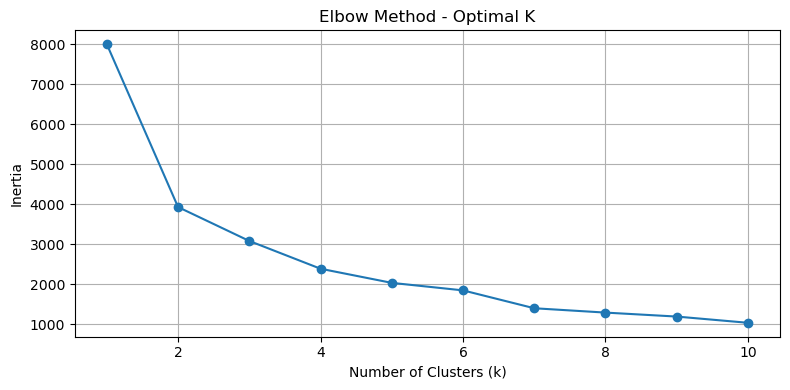

In [38]:
# Ploting the Elbow
plt.figure(figsize=(8,4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method - Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.tight_layout()
plt.grid(True)
plt.show()

In [39]:
from sklearn.metrics import silhouette_score

In [40]:
# Using 3 segments for simplicity
kmeans = KMeans(n_clusters=3, random_state=60)
df['Cluster'] = kmeans.fit_predict(scaled_features)
labels = kmeans.fit_predict(scaled_features)

# Checking the model score
score = silhouette_score(scaled_features, labels)
print(f"Silhouette Score for k=3: {score:.4f}")

Silhouette Score for k=3: 0.4958


In [41]:
# Displaying the entire dataframe 
df

,Brand,Model,RAM,ROM,Screen,Android,Color,Price,Review,Price_Segment,Cluster
0,XIAOMI,REDMI PAD SE,4.0,128.0,4.0,Android 13,Grey,221160.0,4.5,Upper-Mid,0
1,XIAOMI,REDMI A5,3.0,64.0,5.0,Android 15,Black,96659.0,4.2,Lower-Mid,0
2,XIAOMI,REDMI A5,4.0,128.0,5.0,Android 15,Ocean blue,111684.0,4.1,Lower-Mid,0
3,SAMSUNG,GALAXY A05,4.0,64.0,5.0,Android 13,Black,120577.0,4.0,Lower-Mid,0
4,XIAOMI,REDMI A5,4.0,128.0,5.0,Android 15,Black,109450.0,4.1,Lower-Mid,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,XIAOMI,REDMI A3X,3.0,64.0,3.0,Android 14,Black,88316.0,4.4,Lower-Mid,0
1996,ITEL,S24,8.0,256.0,24.0,Android 13,Blue,130008.0,4.3,Lower-Mid,1
1997,INFINIX,HOT 50 PRO,8.0,128.0,50.0,Android 14,Purple,256317.0,4.5,Upper-Mid,1
1998,REDBEAT,D5 SMARTPHONE,3.0,128.0,5.0,Android 14,Black,92800.0,3.4,Lower-Mid,2


In [42]:
# mapping the clusters
cluster_labels = {
    0: 1,
    1: 2,
    2: 3
}
df["Cluster"] = df["Cluster"].map(cluster_labels)

In [43]:
df.head()

,Brand,Model,RAM,ROM,Screen,Android,Color,Price,Review,Price_Segment,Cluster
0,XIAOMI,REDMI PAD SE,4.0,128.0,4.0,Android 13,Grey,221160.0,4.5,Upper-Mid,1
1,XIAOMI,REDMI A5,3.0,64.0,5.0,Android 15,Black,96659.0,4.2,Lower-Mid,1
2,XIAOMI,REDMI A5,4.0,128.0,5.0,Android 15,Ocean blue,111684.0,4.1,Lower-Mid,1
3,SAMSUNG,GALAXY A05,4.0,64.0,5.0,Android 13,Black,120577.0,4.0,Lower-Mid,1
4,XIAOMI,REDMI A5,4.0,128.0,5.0,Android 15,Black,109450.0,4.1,Lower-Mid,1


In [44]:
# Displaying each cluster counts
df["Cluster"].value_counts()

Cluster
1    1300
2     600
3     100
Name: count, dtype: int64

In [45]:
# Calculate the mean of all numeric columns for each cluster
        # This provides the average feature values per cluster, helping to profile cluster characteristics

summ = df.groupby("Cluster").mean(numeric_only = True)
summ

,RAM,ROM,Screen,Price,Review
Cluster,,,,,
1,3.864615,98.461538,12.0,106590.038462,4.184615
2,8.000000,213.333333,36.5,176977.666667,4.408333
3,3.000000,128.000000,5.5,82625.000000,3.250000


In [46]:
# Map numeric cluster numbers to descriptive names for better interpretation
    # This replaces numeric labels with meaningful business-oriented categories

cluster_labels_b = {
    1: "Premium-Product",
    2: "Top-Tier (High Premium - Spec)",
    3: "Mid-Tier (Low Budget)"
}

# Create a new column with the descriptive cluster names
df["Cluster_Label"] = df["Cluster"].map(cluster_labels_b)

# Display the first few rows with selected columns for quick verification
df[['Brand', 'Model', 'RAM', 'ROM', 'Screen', 'Price', 'Review', 'Cluster', 'Cluster_Label']].head()


,Brand,Model,RAM,ROM,Screen,Price,Review,Cluster,Cluster_Label
0,XIAOMI,REDMI PAD SE,4.0,128.0,4.0,221160.0,4.5,1,Premium-Product
1,XIAOMI,REDMI A5,3.0,64.0,5.0,96659.0,4.2,1,Premium-Product
2,XIAOMI,REDMI A5,4.0,128.0,5.0,111684.0,4.1,1,Premium-Product
3,SAMSUNG,GALAXY A05,4.0,64.0,5.0,120577.0,4.0,1,Premium-Product
4,XIAOMI,REDMI A5,4.0,128.0,5.0,109450.0,4.1,1,Premium-Product


In [47]:
# Aggregate smartphone data at the model level:
    # - 'count': number of listings per model (helps identify most common models)
    # - 'avg_review': average price per model (despite variable name, this is price-based)

phone_stats = df.groupby("Model").agg(
    count=("Price", "count"),     # Count how many times each model appears
    avg_review=("Price", "mean")  # Calculate the average price for each model
)

# Sort models by listing count in descending order to see the most frequently listed models first

phone_stats = phone_stats.sort_values("count", ascending=False)

# Display the top 5 models with their counts and average prices
phone_stats.head()


,count,avg_review
Model,,
REDMI A5,250,105227.200000
REDMI 14C,150,141878.666667
S24,150,125365.666667
CITY 100,150,114411.000000
S25 ULTRA,100,212989.500000


In [48]:
# Create a pivot table showing the distribution of each phone model across cluster categories
    # - index="Model": each row represents a unique phone model
    # - columns="Cluster_Label": each column is a descriptive cluster category
    # - values="Cluster": use cluster IDs as values (will be aggregated, here just counting occurrences)
    # - fillna(0): replace missing values with 0 to indicate no occurrence in that cluster

phone_model_matrix = df.pivot_table(
    index="Model",
    columns="Cluster_Label",
    values="Cluster"
).fillna(0)

# Display the first 20 models (transposed for better readability by showing clusters as rows)
phone_model_matrix.head(20).T

Model,105 AFRICAN EDITION,2165 WIRELESS FM,C61,C71,C75X,CITY 100,D5 SMARTPHONE,GALAXY A,GALAXY A05,GALAXY A06,HOT 50 PRO,M5,POP 9,POVA6,POWER 70,REDMI 14C,REDMI A3 PRO,REDMI A3X,REDMI A5,REDMI NOTE 14
Cluster_Label,,,,,,,,,,,,,,,,,,,,
Mid-Tier (Low Budget),0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
Premium-Product,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
Top-Tier (High Premium - Spec),0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0


# Part 2: Recommendation System (Based on Reviews & Specs)
**• Recommendation Model (Content-Based Filtering)**  
To suggest similar phones to customers based on a selected phone's features. This model recommends products with similar price-performance ratios, specifications, and reviews — enabling personalized suggestions like **"You may also like..."**.

In [50]:
# Compute cosine similarity between phone models based on their cluster distribution
cos_sim = cosine_similarity(phone_model_matrix)

# Convert similarity matrix to a DataFrame with models as both rows and columns
cos_sim_df = pd.DataFrame(cos_sim, index=phone_model_matrix.index, columns=phone_model_matrix.index)

In [51]:
# Display the cosine similarity matrix for all phone models
cos_sim_df

Model,105 AFRICAN EDITION,2165 WIRELESS FM,C61,C71,C75X,CITY 100,D5 SMARTPHONE,GALAXY A,GALAXY A05,GALAXY A06,...,REDMI 14C,REDMI A3 PRO,REDMI A3X,REDMI A5,REDMI NOTE 14,REDMI PAD SE,S23,S24,S25 ULTRA,T101
Model,,,,,,,,,,,,,,,,,,,,,
105 AFRICAN EDITION,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.316228,1.000000,1.000000,1.000000,...,0.447214,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
2165 WIRELESS FM,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.316228,1.000000,1.000000,1.000000,...,0.447214,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
C61,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.316228,1.000000,1.000000,1.000000,...,0.447214,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
C71,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.316228,1.000000,1.000000,1.000000,...,0.447214,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
C75X,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.894427,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
CITY 100,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.316228,1.000000,1.000000,1.000000,...,0.447214,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
D5 SMARTPHONE,0.316228,0.316228,0.316228,0.316228,0.000000,0.316228,1.000000,0.316228,0.316228,0.316228,...,0.141421,0.316228,0.316228,0.316228,0.000000,0.316228,0.000000,0.000000,0.000000,0.316228
GALAXY A,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.316228,1.000000,1.000000,1.000000,...,0.447214,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
GALAXY A05,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.316228,1.000000,1.000000,1.000000,...,0.447214,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000


In [105]:
# Recommend similar phone models based on cosine similarity scores

def phone_recommendation(phone_model, top_n=10):
   
    # Check if model exists in similarity matrix
    if phone_model not in cos_sim_df:
        return f"'{phone_model}' not found in model list. Try another model."
    
    # Sort similarity scores in descending order
    sim_score = cos_sim_df[phone_model].sort_values(ascending=False)
    
    # Get top N most similar models (excluding the model itself)
    recomm_cos_sim_df = sim_score[1:top_n+1].index
    
    # Return details of the top recommendations
    return df[df["Model"].isin(recomm_cos_sim_df)].head()

In [113]:
# Testing the recommender system model

phone_recommendation("D5 SMARTPHONE")

,Brand,Model,RAM,ROM,Screen,Android,Color,Price,Review,Price_Segment,Cluster,Cluster_Label
0,XIAOMI,REDMI PAD SE,4.0,128.0,4.0,Android 13,Grey,221160.0,4.5,Upper-Mid,1,Premium-Product
1,XIAOMI,REDMI A5,3.0,64.0,5.0,Android 15,Black,96659.0,4.2,Lower-Mid,1,Premium-Product
2,XIAOMI,REDMI A5,4.0,128.0,5.0,Android 15,Ocean blue,111684.0,4.1,Lower-Mid,1,Premium-Product
4,XIAOMI,REDMI A5,4.0,128.0,5.0,Android 15,Black,109450.0,4.1,Lower-Mid,1,Premium-Product
8,NOKIA,105 AFRICAN EDITION,3.0,64.0,10.0,Android 14,Charcoal,12005.0,4.2,Low,1,Premium-Product


In [115]:
phone_recommendation("C75X")

,Brand,Model,RAM,ROM,Screen,Android,Color,Price,Review,Price_Segment,Cluster,Cluster_Label
0,XIAOMI,REDMI PAD SE,4.0,128.0,4.0,Android 13,Grey,221160.0,4.5,Upper-Mid,1,Premium-Product
1,XIAOMI,REDMI A5,3.0,64.0,5.0,Android 15,Black,96659.0,4.2,Lower-Mid,1,Premium-Product
2,XIAOMI,REDMI A5,4.0,128.0,5.0,Android 15,Ocean blue,111684.0,4.1,Lower-Mid,1,Premium-Product
4,XIAOMI,REDMI A5,4.0,128.0,5.0,Android 15,Black,109450.0,4.1,Lower-Mid,1,Premium-Product
5,REALME,C75X,8.0,256.0,75.0,Android 14,Oceanic blue,214699.0,5.0,Upper-Mid,2,Top-Tier (High Premium - Spec)


In [111]:
phone_recommendation("REDMI 14C")

,Brand,Model,RAM,ROM,Screen,Android,Color,Price,Review,Price_Segment,Cluster,Cluster_Label
0,XIAOMI,REDMI PAD SE,4.0,128.0,4.0,Android 13,Grey,221160.0,4.5,Upper-Mid,1,Premium-Product
1,XIAOMI,REDMI A5,3.0,64.0,5.0,Android 15,Black,96659.0,4.2,Lower-Mid,1,Premium-Product
2,XIAOMI,REDMI A5,4.0,128.0,5.0,Android 15,Ocean blue,111684.0,4.1,Lower-Mid,1,Premium-Product
4,XIAOMI,REDMI A5,4.0,128.0,5.0,Android 15,Black,109450.0,4.1,Lower-Mid,1,Premium-Product
5,REALME,C75X,8.0,256.0,75.0,Android 14,Oceanic blue,214699.0,5.0,Upper-Mid,2,Top-Tier (High Premium - Spec)
